In [1]:
import random
import time
import enum
import math
from collections import namedtuple
from multiprocessing.pool import Pool
from typing import Tuple, NamedTuple, List
from tqdm import tqdm

import numpy as np
import pandas as pd
import pylab as plt
import networkx as nx
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import colors as c
import matplotlib as mpl
import networkx as nx

import plotnine as p9
from scipy.stats import sem

from lib.networkgen import Network, NetworkType
from lib.model import OpinionModel, OpinionAgent, Opinion

In [106]:
#n, p = 100, 0.3 # DEFAULT
#n, k, p = 100, 10, 0.2 # SMALLWORLD
#l, k = 10, 5 # CAVEMAN
#n, s, v, p_in, p_out = 100, 5, 10, 0.3, 0.1 # GAUSSIAN_RANDOM_PARTITION
#n, k = 100, 10 # WINDMILL
#n, p = 100, 0.02  # ERDOS_RENYI
l, k, p, f = 6, 5, 0.1, 0.1 # RELAXED_CAVEMAN

network_params = (l, k, p, f)

initial_believers = 0.1
initial_skeptics = 0.0  # for now 0, but might change later

prob_S_with_I = 0.1
prob_S_with_Z = 0.2
neighbor_threshold = 0.8 # percentage of neighbors that need to have a certain opinion, for the agent to change his own opinion to it, set to None if you want to deactivate this
agent_params = OpinionAgent.Params(
    initial_opinion=Opinion.SUSCEPTIBLE,
    prob_S_with_I=prob_S_with_I,
    prob_S_with_Z=prob_S_with_Z,
    neighbor_threshold=neighbor_threshold
)

model = OpinionModel(initial_believers, initial_skeptics, agent_params, network_type=NetworkType.RELAXED_CAVEMAN, network_params=network_params)

In [73]:
model.run(15)

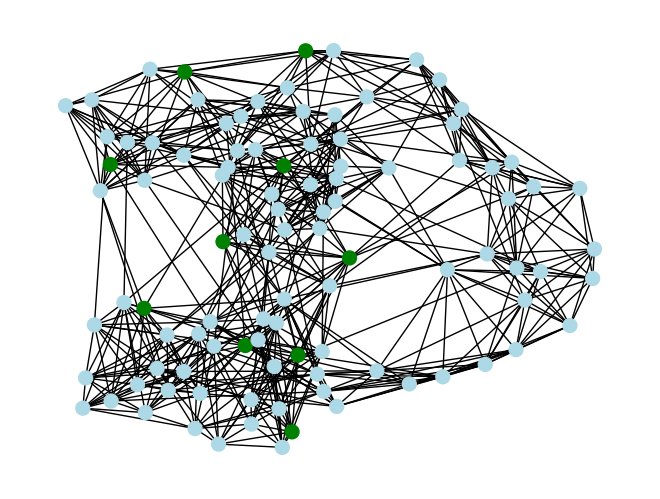

In [59]:
# nicer network figure where nodes are color coded  

model = OpinionModel(initial_believers, initial_skeptics, agent_params, network_type=NetworkType.SMALLWORLD, network_params=network_params)
     
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

color_code = ListedColormap(["lightblue", "orange", "green",])
states = [int(i.state) for i in model.grid.get_all_cell_contents()]
colors = [color_code(i) for i in states]
nx.draw(model.network, node_size = 100, edge_color = 'black', node_color = colors)
# colors look wrong here

In [75]:
#convenience function to collect plotable data
def sum_agents(model):

    agent_data = model.data_collector.get_agent_vars_dataframe()
    # sum up different opinions each (time) step
    agents_summed = pd.pivot_table(agent_data.reset_index(), index = 'Step', columns = 'State', aggfunc = np.size, fill_value = 0)
    # relabel
    labels = ['Susceptible','Exposed', 'Skeptic', "Infected"]
    agents_summed.columns = labels
    return agents_summed

sum_agents(model)

,Susceptible,Exposed,Skeptic,Infected
Step,,,,
0,90,0,0,10
1,76,12,0,12
2,69,17,1,13
3,61,21,3,15
4,51,25,8,16
5,40,35,9,16
6,34,33,13,20
7,23,34,21,22
8,16,33,26,25


In [147]:
def run_replicates(n_replicates, n_steps): 
    
    for i in range(n_replicates):
        
        #(re-)initiate model
        model = OpinionModel(initial_believers, initial_skeptics, agent_params, network_type=NetworkType.SMALLWORLD, network_params=network_params) 
        
        #run model
        model.run(n_steps)
                
        #data collection
        if i == 0: 
            replicates = sum_agents(model)
        else:
            replicates = pd.concat([replicates, sum_agents(model)])
       
    #calculate means and standard error of the mean
    replicates = pd.pivot_table(replicates, index = ["Step"], aggfunc = [np.mean, sem])
       
    return replicates


In [140]:
def plot_replicate_trajectories(data, colors_ggplot = {"Susceptible":'cornflowerblue', "Infected":'red', "Skeptic":"green", "Exposed":"orange"}):
    
    
    # data wrangling for ggplot 
    data = data.stack(level=1).reset_index(1).rename(columns={"level_1": "Population"}).sort_values("Population")
    data.reset_index(inplace=True)
    data = data.rename(columns = {'index':'Step'})
    
    #ggplot
    plot = (p9.ggplot(data, p9.aes(x = 'Step', y = "mean", fill = "Population", group = "Population", color = "Population"))
    + p9.geom_line()
    + p9.geom_ribbon(p9.aes(x = 'Step', ymin = data["mean"] - data["sem"], ymax = data["mean"] + data["sem"]), outline_type = "none", alpha = 0.25, show_legend = False)
    + p9.ylab("Population size")
    + p9.xlab("Step")
    + p9.scale_color_manual(values = colors_ggplot)
    + p9.scale_fill_manual(values = colors_ggplot) 
    + p9.ylim(0, max(data['mean']))
    + p9.theme_classic()
    )
    
    return plot

100


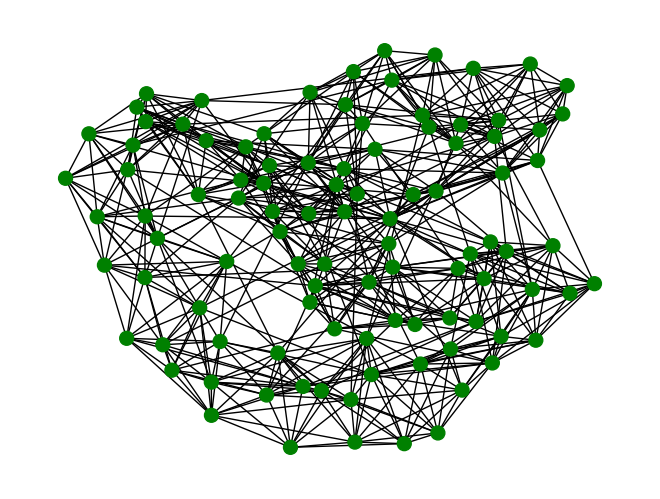

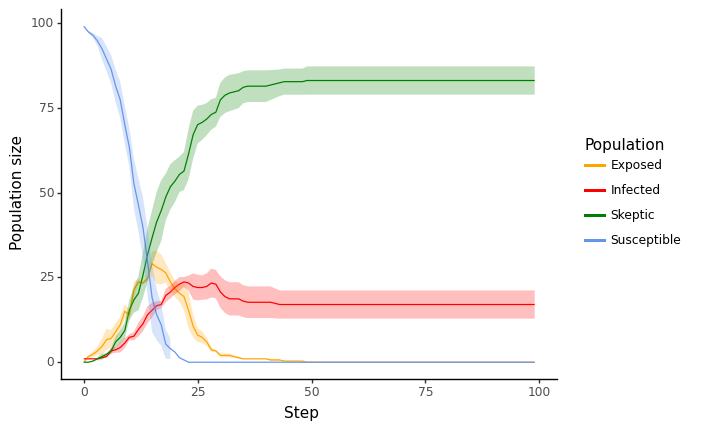

<ggplot: (164535119845)>

In [148]:

df = run_replicates(3, 100)
plot_replicate_trajectories(df)


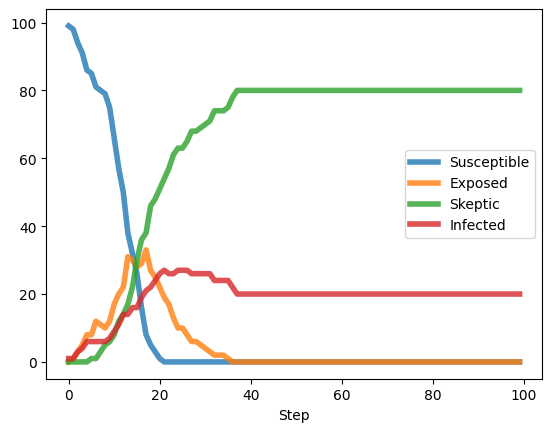

In [137]:

def plot_agent_opinion(model):
    steps = model.schedule.steps
    X = sum_agents(model)
    X.plot(lw = 4, alpha = 0.8)

model = OpinionModel(initial_believers, initial_skeptics, agent_params, network_type=NetworkType.SMALLWORLD, network_params=network_params)
model.run(100)
plot_agent_opinion(model)

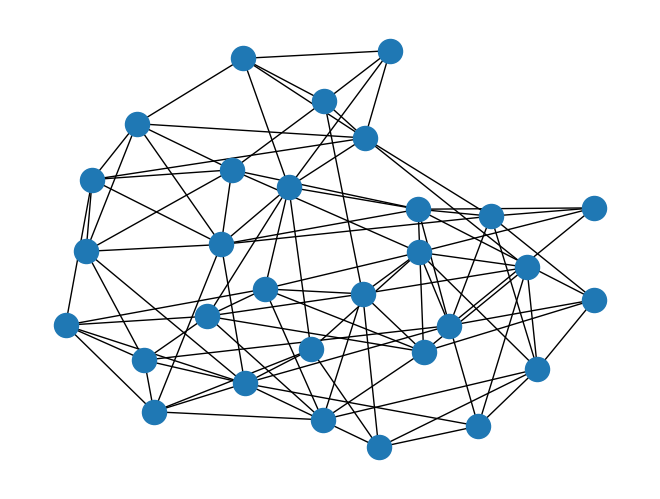

In [279]:
Network.visualize(NetworkType.RELAXED_CAVEMAN, model.network)

30.88


AttributeError: module 'pylab' has no attribute 'legend'

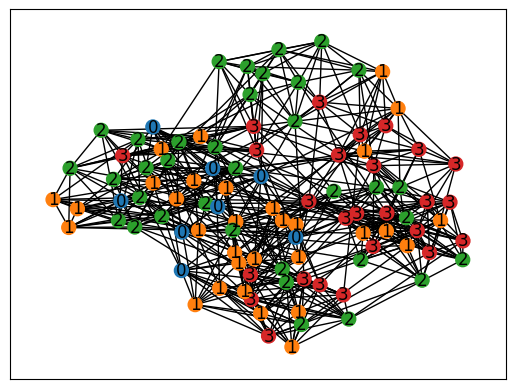

In [80]:
#color_code = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

#states = [int(i.state) for i in model.grid.get_all_cell_contents()]

#colors = [color_code(i) for i in states]

from matplotlib.lines import Line2D

def draw_network(with_labels=False):
    node_states = [int(i.state) for i in model.grid.get_all_cell_contents()]
    cmap = ListedColormap(list(mpl.colors.TABLEAU_COLORS.values())[:4])

    legend = [Line2D([0], [0], color=cmap(0), lw=3),
                Line2D([0], [0], color=cmap(1), lw=3),
                Line2D([0], [0], color=cmap(2), lw=3),
                    Line2D([0], [0], color=cmap(3), lw=3)]
    #node_color = [cmap[s] for s in node_states]
    #edge_weights = [model.network.edges[u, v]['weight'] for u, v in model.network.edges]
    #layout = nx.kamada_kawai_layout(model.network, weight=1.0, scale=10)
    dummy = nx.connected_caveman_graph(6, 5)
    #layout=nx.kamada_kawai_layout(dummy)
    layout = nx.spring_layout(model.network, scale=10)
    nx.draw_networkx(model.network, pos=layout, node_size = 100, arrowsize=5.0, vmin=0, vmax=3,node_color=node_states, cmap=cmap, with_labels=with_labels, labels={i: node_states[i] for i in range(len(node_states))})
    #plt.colorbar(plt.cm.ScalarMappable(norm=mpl.colors.Normalize(0,1), cmap=cmap))
    plt.legend(legend, ['Susceptible','Exposed', 'Skeptic', "Infected"])

print(np.mean(model.network.degree()))
draw_network(True)

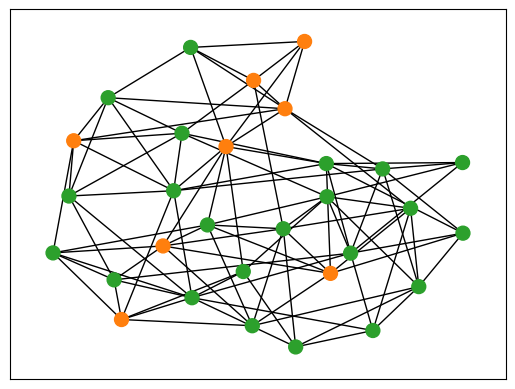

In [281]:
def draw_network_discrete():
    color_code = ListedColormap(['#1f77b4', '#ff7f0e', '#2ca02c'])

    states = [int(i.state) for i in model.grid.get_all_cell_contents()]

    colors = [color_code(i) for i in states]

    layout = nx.kamada_kawai_layout(model.network, weight=1.0, scale=10)
    nx.draw_networkx(model.network, pos=layout, node_size = 100, arrowsize=5.0, width=1.0, node_color=colors, with_labels=False)

draw_network_discrete()

  0%|          | 0/20 [00:00<?, ?it/s]

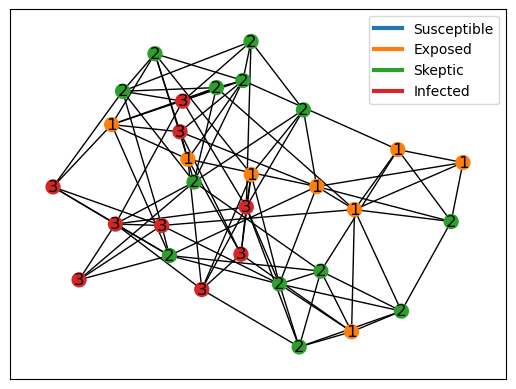

  5%|▌         | 1/20 [00:00<00:01,  9.83it/s]

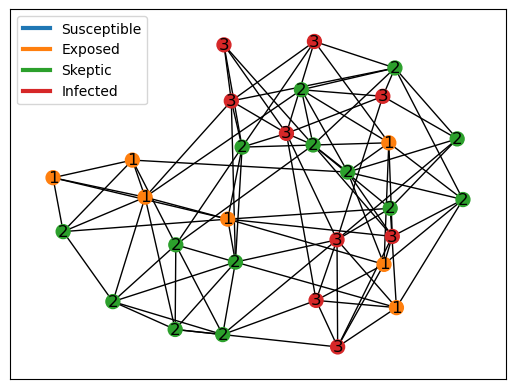

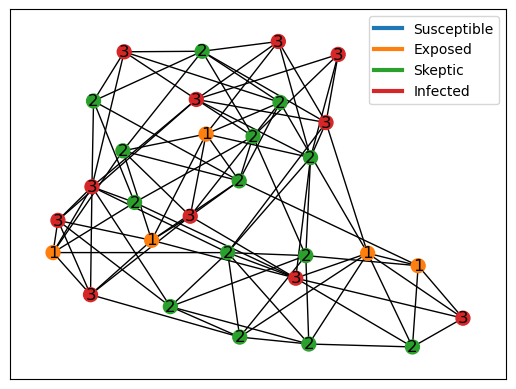

 15%|█▌        | 3/20 [00:00<00:01, 10.33it/s]

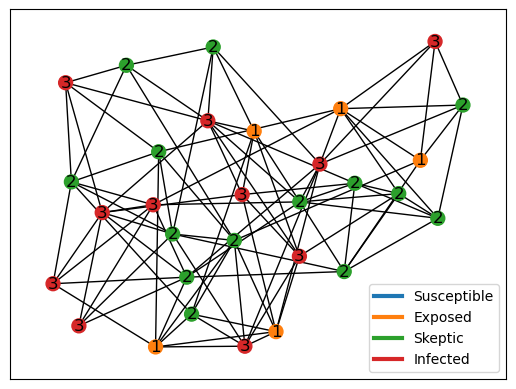

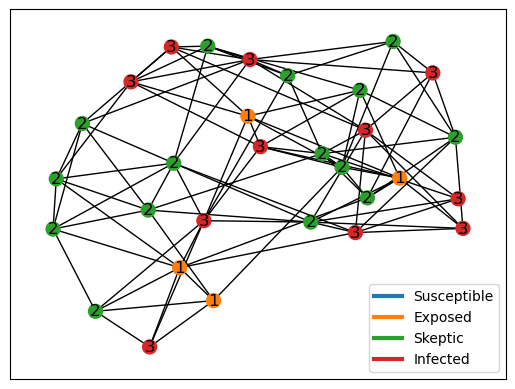

 25%|██▌       | 5/20 [00:00<00:01, 10.52it/s]

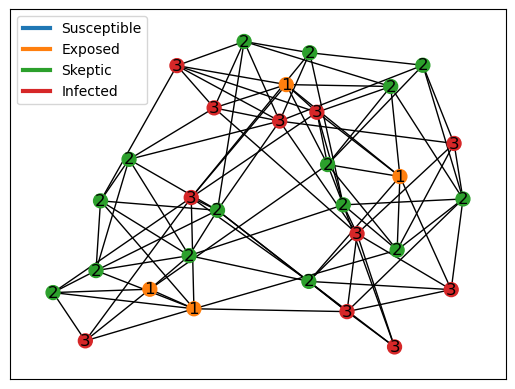

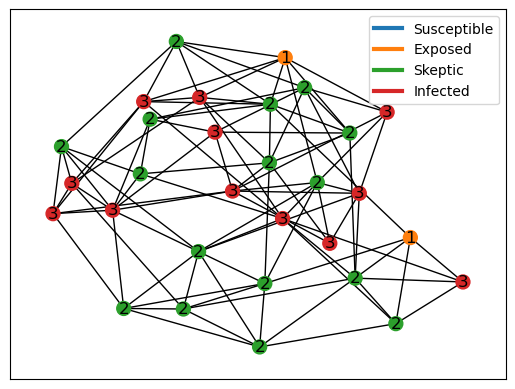

 35%|███▌      | 7/20 [00:00<00:01, 10.65it/s]

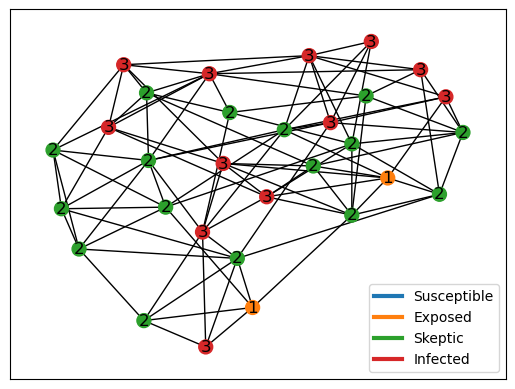

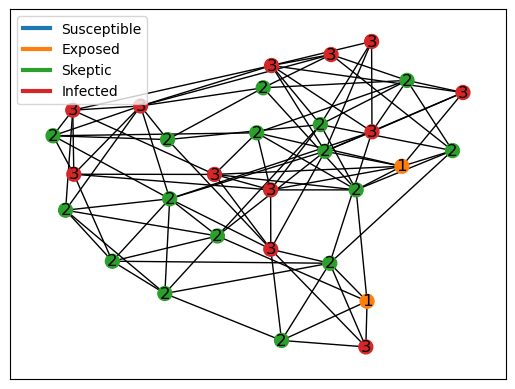

 45%|████▌     | 9/20 [00:00<00:01, 10.55it/s]

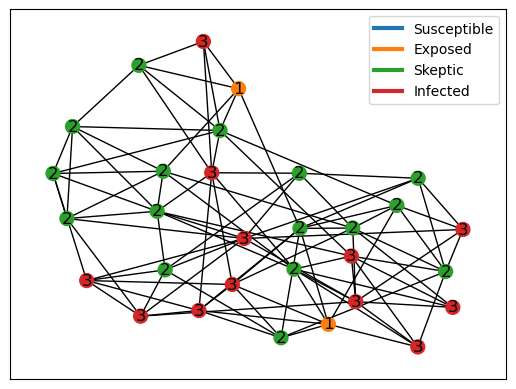

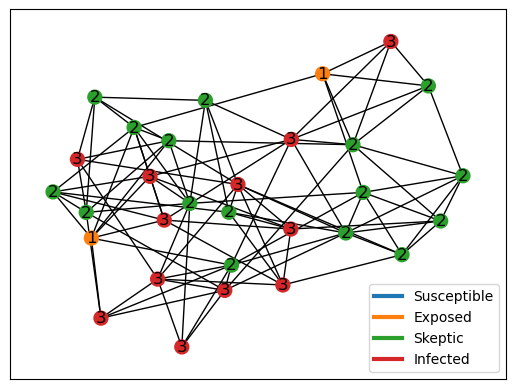

 55%|█████▌    | 11/20 [00:01<00:00, 10.32it/s]

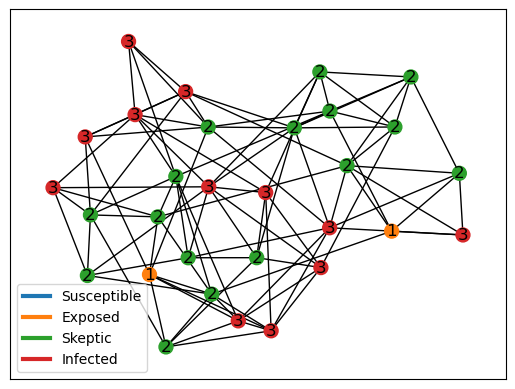

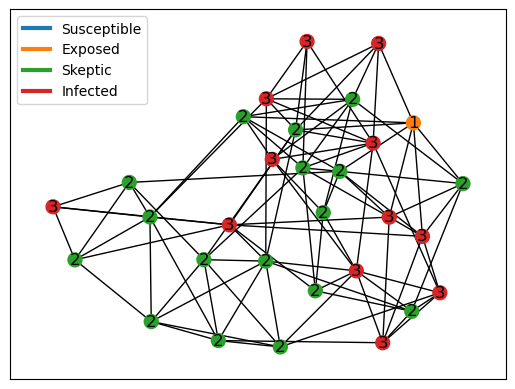

 65%|██████▌   | 13/20 [00:01<00:00,  9.98it/s]

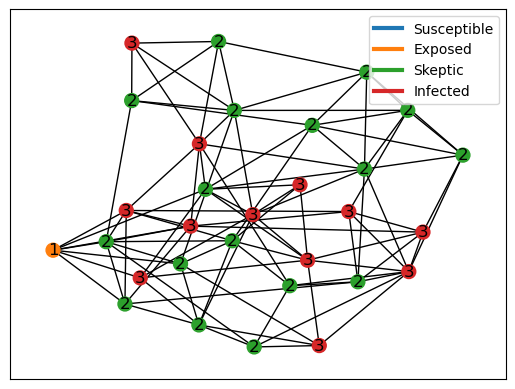

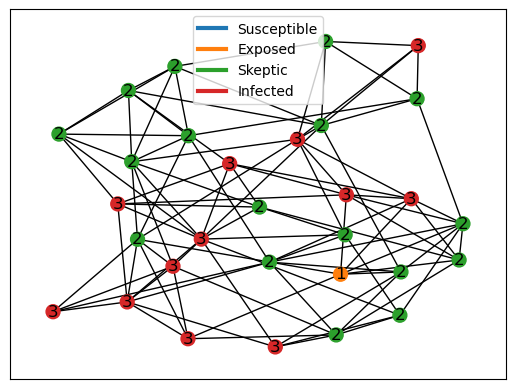

 75%|███████▌  | 15/20 [00:01<00:00,  8.17it/s]

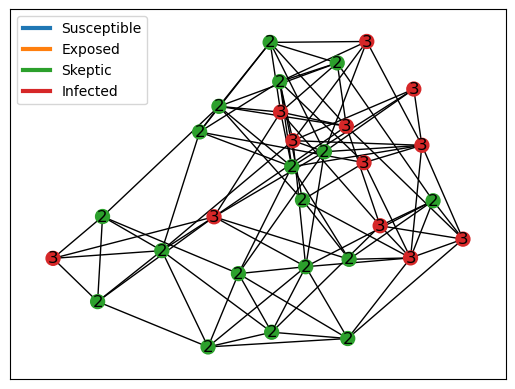

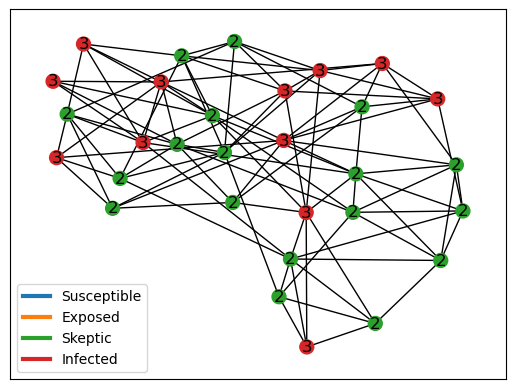

 85%|████████▌ | 17/20 [00:01<00:00,  8.73it/s]

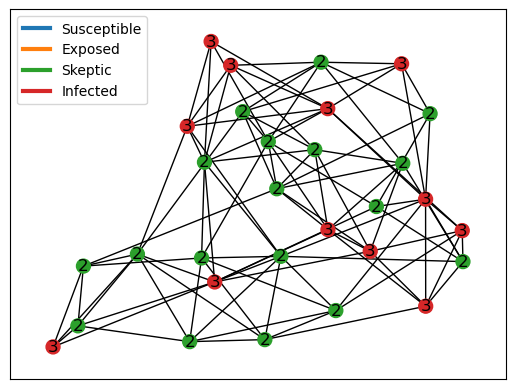

 90%|█████████ | 18/20 [00:01<00:00,  8.85it/s]

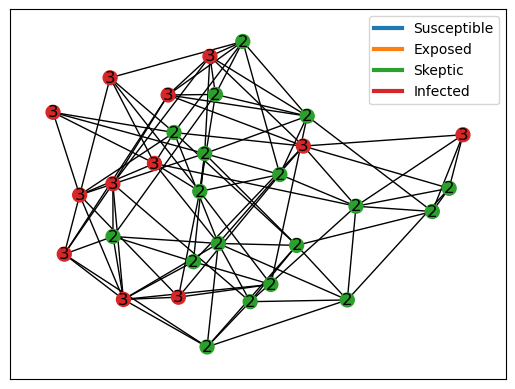

 95%|█████████▌| 19/20 [00:02<00:00,  9.02it/s]

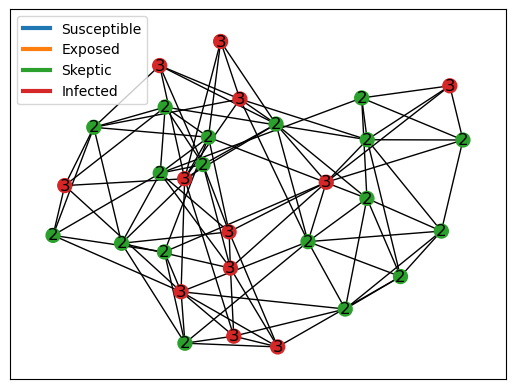

100%|██████████| 20/20 [00:02<00:00,  9.47it/s]


In [282]:
for i in tqdm(range(20)):
    #print(f"i={i}")
    ##draw_network_discrete()
    draw_network(True)
    plt.show()
    if i % 100 == 0 and False:
        plt.hist([agent.state for agent in model.grid.get_all_cell_contents()], range=(0,1), bins=20)
        plt.show()
    model.step()

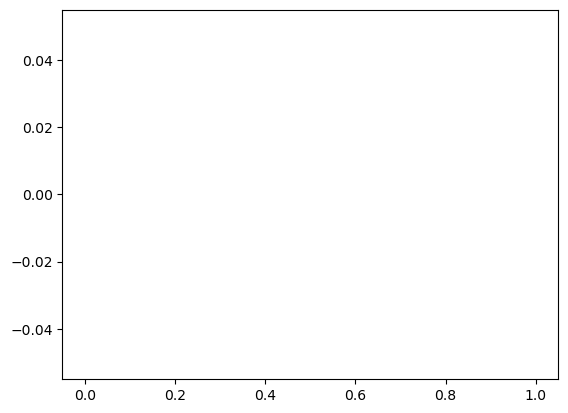

In [283]:
def draw_histogram():
    # This is  the colormap I'd like to use.
    cm = plt.cm.plasma

    # Plot histogram.
    n, bins, patches = plt.hist([agent.state for agent in model.grid.get_all_cell_contents()], range=(0,1), bins=20)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    # scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)

    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cm(c))

draw_histogram()

In [284]:
[agent.state for agent in model.grid.get_all_cell_contents()]

[<Opinion.INFECTED: 3>,
 <Opinion.INFECTED: 3>,
 <Opinion.INFECTED: 3>,
 <Opinion.INFECTED: 3>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.INFECTED: 3>,
 <Opinion.INFECTED: 3>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.INFECTED: 3>,
 <Opinion.INFECTED: 3>,
 <Opinion.INFECTED: 3>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.INFECTED: 3>,
 <Opinion.INFECTED: 3>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.INFECTED: 3>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>,
 <Opinion.SKEPTIC: 2>]

In [285]:
list(mpl.colors.TABLEAU_COLORS.values())

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

In [393]:
z = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        #n, p = 100, 0.3 # DEFAULT
        #n, k, p = 100, 10, 0.2 # SMALLWORLD
        #l, k = 10, 5 # CAVEMAN
        #n, s, v, p_in, p_out = 100, 5, 10, 0.3, 0.1 # GAUSSIAN_RANDOM_PARTITION
        #n, k = 100, 10 # WINDMILL
        #n, p = 100, 0.02  # ERDOS_RENYI
        l, k, p, f = 6, 5, 0.1, 0.1 # RELAXED_CAVEMAN
        #l, n, m = 6, 6, 5 #STAR_CLIQUE

        network_params = (l, k, p, f)

        initial_believers = 0.1
        initial_skeptics = 0.2  # for now 0, but might change later

        prob_S_with_Z = 0.2
        #prob_S_with_Z = j / 20

        #prob_S_with_I = 0.1
        prob_S_with_I = j / 20

        #neighbor_threshold = 0.8 # percentage of neighbors that need to have a certain opinion, for the agent to change his own opinion to it, set to None if you want to deactivate this
        neighbor_threshold = j / 20

        agent_params = OpinionAgent.Params(
            initial_opinion=Opinion.SUSCEPTIBLE,
            prob_S_with_I=prob_S_with_I,
            prob_S_with_Z=prob_S_with_Z,
            neighbor_threshold=neighbor_threshold
        )

        model = OpinionModel(i / 20 * 0.8, initial_skeptics, agent_params, network_type=NetworkType.RELAXED_CAVEMAN, network_params=network_params)
        model.run(25)

        #max occurences formula
        results = [agent.state for agent in model.grid.get_all_cell_contents()]
        z[19-i][19-j] = max(set(results), key = results.count)

        #mean formula
        #z[i][j] = sum([agent.state for agent in model.grid.get_all_cell_contents()])/len([agent.state for agent in model.grid.get_all_cell_contents()])


In [398]:
def draw_phase_diagram(r):
    
    x = np.linspace(0, 1, 20)
    y = np.linspace(0, 1, 20)

    """
    z = gaussian_filter(r, sigma=7, mode='wrap')
    z -= np.min(z)
    z /= np.max(z)
    """

    #
    z = r

    fig, ax = plt.subplots()
    cMap = c.ListedColormap([
 '#2ca02c',
 '#d62728'])
    cmap = ax.pcolormesh(x, y, z, cmap = cMap)
    fig.colorbar(cmap)
    plt.xlabel("Initial believers")
    plt.ylabel("Probability of a susceptible of becoming an infected when interacting with one")
    #"Probability of a susceptible of becoming skeptical when interacting with one"
    plt.show(fig)


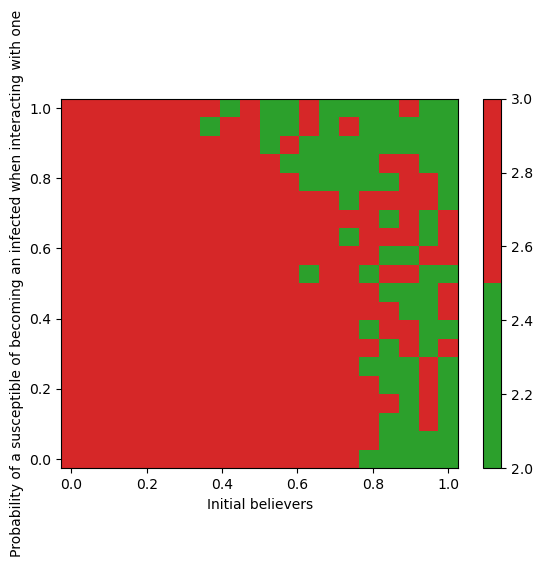

In [399]:
draw_phase_diagram(z)